### Importación de las librerías que se utilizarán

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Cargo el dataset desde un archivo CSV y lo convierto en un dataframe

In [66]:
df_bank = pd.read_csv('bank_dataset.CSV', header=0, delimiter= ",")

Elimino las variables/columnas que no necesitaré para el proyecto, esto lo realizo para tener un dataframe más ligero.

In [67]:
df_bank = df_bank.drop(columns=['contact', 'default', 'day', 'month', 'duration','campaign', 'pdays','poutcome', 'previous'])

Muestro las primeras filas para ver que se han cargado correctamente.

In [68]:
df_bank.head()

,age,job,marital,education,balance,housing,loan,deposit
0,59.0,admin.,married,secondary,2343,yes,no,yes
1,56.0,admin.,married,secondary,45,no,no,yes
2,41.0,technician,married,secondary,1270,yes,no,yes
3,55.0,services,married,secondary,2476,yes,no,yes
4,54.0,admin.,married,tertiary,184,no,no,yes


Compruebo la existencia de valores nulos dentro del dataset

In [69]:
df_bank.isnull().sum()

age          10
job           0
marital       5
education     7
balance       0
housing       0
loan          0
deposit       0
dtype: int64

En el dataset las siguientes columnas tienen valores nulos:

- `age`: 10
- `marital`: 5
- `education`: 7

Estos valores nulos pertenecen a variables que utilizaré durante el proyecto, por lo tanto, trabajaré en sustituir los valores faltantes.

En primer lugar los filtraré por variable para saber como trabajar con ellos en su imputación

Variable `AGE`. Muestro los registros que contienen los valores nulos y estudiar la manera de tratar estos nulos.

In [70]:
nulos_age = df_bank['age'].isnull()
df_bank[nulos_age]

,age,job,marital,education,balance,housing,loan,deposit
1181,NaN,management,married,tertiary,309,yes,no,yes
1410,NaN,blue-collar,married,primary,4979,no,no,yes
4019,NaN,services,single,secondary,1934,no,no,yes
5680,NaN,technician,single,tertiary,720,no,no,no
6763,NaN,technician,single,tertiary,686,yes,no,no
8419,NaN,blue-collar,married,secondary,1782,yes,no,no
9470,NaN,management,married,tertiary,552,no,no,no
9552,NaN,admin.,married,secondary,1648,yes,no,no
9751,NaN,services,married,primary,2567,yes,no,no
10678,NaN,technician,divorced,tertiary,0,yes,no,no


En el caso de `age` utilizaré la media de `marital` para completar los valores faltantes

In [71]:
avg_ages = df_bank.groupby("marital")["age"].mean().round()

for status, avg_age in avg_ages.items():
    df_bank.loc[(df_bank["marital"] == status) & (df_bank["age"].isna()), "age"] = avg_age

En la variable `age` observo también que los valores dentro de esta presentan números decimales y es del tipo (float); cambio el tipo a (int)

In [72]:
df_bank['age'] = df_bank['age'].astype('int')

Variable `marital`. Muestro los registros que contienen los valores nulos y estudiar la manera de tratar estos nulos.

In [73]:
nulos_marital = df_bank['marital'].isnull()
df_bank[nulos_marital]

,age,job,marital,education,balance,housing,loan,deposit
1088,53,management,NaN,secondary,1004,no,yes,yes
3719,68,retired,NaN,secondary,4189,no,no,yes
4854,34,management,NaN,tertiary,5,no,no,yes
6701,60,admin.,NaN,primary,-444,no,yes,no
9272,30,blue-collar,NaN,primary,35,yes,no,no


En el caso de la variable `marital` mediante la moda, utilizando las columnas `job` y `age` para imputar los valores nulos de cada registro

In [74]:
moda_marital = df_bank.groupby(['job', 'age'])['marital'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df_bank['marital'] = df_bank['marital'].fillna(moda_marital)

Variable `education`. Muestro los registros que contienen los valores nulos y estudiar la manera de tratarlos.

In [75]:
nulos_education = df_bank['education'].isnull()
df_bank[nulos_education]

,age,job,marital,education,balance,housing,loan,deposit
1300,37,technician,married,NaN,549,no,no,yes
2943,24,student,single,NaN,382,no,no,yes
4737,37,management,single,NaN,102,yes,no,yes
6819,32,services,married,NaN,-344,no,yes,no
7121,57,entrepreneur,married,NaN,657,no,no,no
8592,55,management,single,NaN,797,no,no,no
9406,32,technician,single,NaN,696,no,yes,no


Para la variable `education` utilizo también la moda teniendo como referencia las columnas `job` y`age` para imputar los valores nulos de cada registro

In [76]:
moda_education = df_bank.groupby(['job', 'age'])['education'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df_bank['education'] = df_bank['education'].fillna(moda_education)

Compruebo que se hayan eliminado los valores nulos

In [77]:
df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
loan         0
deposit      0
dtype: int64

Observo que en la variable de `job` hay muchas categorías, enlisto la cantidad de clientes que hay por cada una; por lo que probaré crear subgrupos para reducir la cantidad de categorías de esta variable, busco no tener muchas columnas cuando realice la codificación de esta variable y su posterior uso al trabajar con el algoritmo (K-MEans Clustering).

In [78]:
cantidades_education = df_bank.groupby('job').size()
print(cantidades_education)

job
admin.           1334
blue-collar      1944
entrepreneur      328
housemaid         274
management       2566
retired           778
self-employed     405
services          923
student           360
technician       1823
unemployed        357
unknown            70
dtype: int64


Decido crear 4 categorías para probar reducir la dimensión de esta variable previo a su codificación, serán:

- profesional(administración, técnicos, dirección y emprendedores)
- manual(obreros, servicios, y empleados del hogar)
- otro(desempleados, estudiantes y desconocidos)
- retired(jubilados)

In [79]:
df_bank['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [80]:
job_mapeo = {
    "admin.": "profesional",
    "technician": "profesional",
    "management": "profesional",
    "entrepreneur": "profesional",
    "self-employed": "profesional",
    "blue-collar": "manual",
    "services": "manual",
    "housemaid": "manual",
    "unemployed": "otro",
    "student": "otro",
    "unknown": "otro",
    "retired": "jubilado"
}

df_bank['job'] = df_bank['job'].replace(job_mapeo)

print(df_bank['job'].value_counts())

job
profesional    6456
manual         3141
otro            787
jubilado        778
Name: count, dtype: int64


Realizaré un análisis de la variable `age` para conocer su distribución y la existencia de outliers. Utilizo un boxplot para tener una visualización de la distribución de los valores de esta variable.

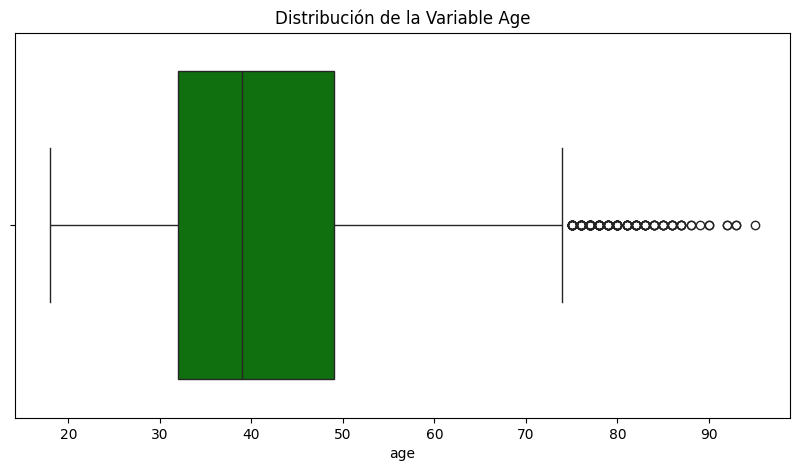

In [81]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_bank['age'], orient='h', color='green')
plt.title('Distribución de la Variable Age')
plt.show()

Como resultado de esta visualización observo que existen valores que se encuentran fuera de rango; creo que puedo profundizar más y saber si pueden estar relacionados con algún error de imputación o de otra índole.

Utilizaré la identificación de estos outliers (`edad`) mediante el método de IQR

In [82]:
# Percentiles
Q3 = df_bank['age'].quantile(0.75)
Q1 = df_bank['age'].quantile(0.25)

# IQR
IQR = Q3 - Q1

# Umbrales
superior = Q3 + (1.5 * IQR)
inferior = Q1 - (1.5 * IQR)
 
outliers_edad = df_bank[(df_bank['age'] < inferior) | (df_bank['age'] > superior)]
outliers_edad

,age,job,marital,education,balance,housing,loan,deposit
1162,75,jubilado,divorced,primary,3881,yes,no,yes
1236,85,jubilado,married,primary,12114,no,no,yes
1243,90,jubilado,divorced,secondary,1,no,no,yes
1274,85,jubilado,divorced,primary,7613,no,no,yes
1320,83,jubilado,divorced,primary,1097,no,no,yes
...,...,...,...,...,...,...,...,...
10438,77,jubilado,married,primary,1492,no,no,no
10562,88,jubilado,married,primary,648,no,no,no
10570,77,otro,married,unknown,397,no,no,no
10618,78,jubilado,married,primary,680,no,no,no


Investigo más sobre los outliers del rango superior, porque en el resultado observo que hay valores 1 en deposit(han contratado un deposito con el banco), filtro los resultados considerando que si hayan contratado uno.

In [83]:
outliers_superior = df_bank[df_bank['age'] > superior]

outliers_deposit_superior_1 = outliers_superior[outliers_superior['deposit'] == "yes"]['deposit'].count()

print(f'Outliers con Deposit 1: {(outliers_deposit_superior_1)}')

Outliers con Deposit 1: 132


Observando la cantidad de clientes del rango superior que si han contratado (con los datos que se tienen), decido conservarlos. A efectos del objetivo de este proyecto, mantener a este grupo de edad para categorizarlo y que pueda ser valioso para crear un producto específico lo considero importante. Aunque después de estudiar la variable `balance` podré determinar utilizar alguna técnica para tratar con estas.

Realizaré ahora un análisis de la variable `balance` y así conocer su distribución y la existencia de outliers. Utilizo un boxplot para tener una visualización de la distribución de los valores de esta variable.

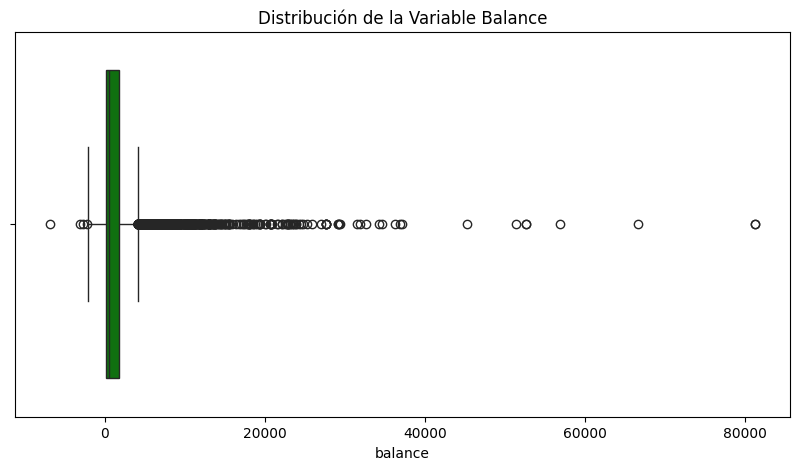

In [84]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_bank['balance'], orient='h', color='green')
plt.title('Distribución de la Variable Balance')
plt.show()

En esta visualización observo que existe una gran cantidad de valores que se encuentran fuera de rango, miraré un poco más en detalle.

Utilizaré la identificación de estos outliers (`balance`) mediante el método de IQR

In [85]:
# Percentiles
Q3 = df_bank['balance'].quantile(0.75)
Q1 = df_bank['balance'].quantile(0.25)

# IQR
IQR = Q3 - Q1

# Umbrales
superior = Q3 + (1.5 * IQR)
inferior = Q1 - (1.5 * IQR)
 
outliers_balance = df_bank[(df_bank['balance'] < inferior) | (df_bank['balance'] > superior)]
outliers_balance

,age,job,marital,education,balance,housing,loan,deposit
9,28,manual,single,secondary,5090,yes,no,yes
60,51,manual,married,secondary,7180,yes,no,yes
61,41,manual,divorced,secondary,5291,yes,no,yes
69,44,profesional,married,tertiary,4580,yes,no,yes
71,29,profesional,married,tertiary,10576,no,no,yes
...,...,...,...,...,...,...,...,...
11073,34,manual,married,primary,6718,no,no,no
11077,54,jubilado,divorced,tertiary,6102,yes,yes,no
11085,60,profesional,married,primary,4243,yes,no,no
11086,42,profesional,married,secondary,6445,yes,no,no


El resultado arroja una gran cantidad de clientes con balances (saldos) que podrían considerarse inusuales; pero en realidad el balance bancario es un valor que puede variar mucho y no necesariamente considerarse como una anomalía, más bien una estado relativo.

De cualquier manera considero utilizar el método de "winsorizar" para tratar los outliers de la variable `balance`; esto tendría un efecto importante al momento de realizar el modelo. 

Creo una copia del Dataframe identificándolo con para poder realizar esta tarea sin necesidad de afectar el Dataframe original.

In [86]:
from scipy.stats.mstats import winsorize

df_bank_w = df_bank.copy()

df_bank_w['balance'] = winsorize(df_bank_w['balance'], limits= [0.05, 0.05], inplace= True)

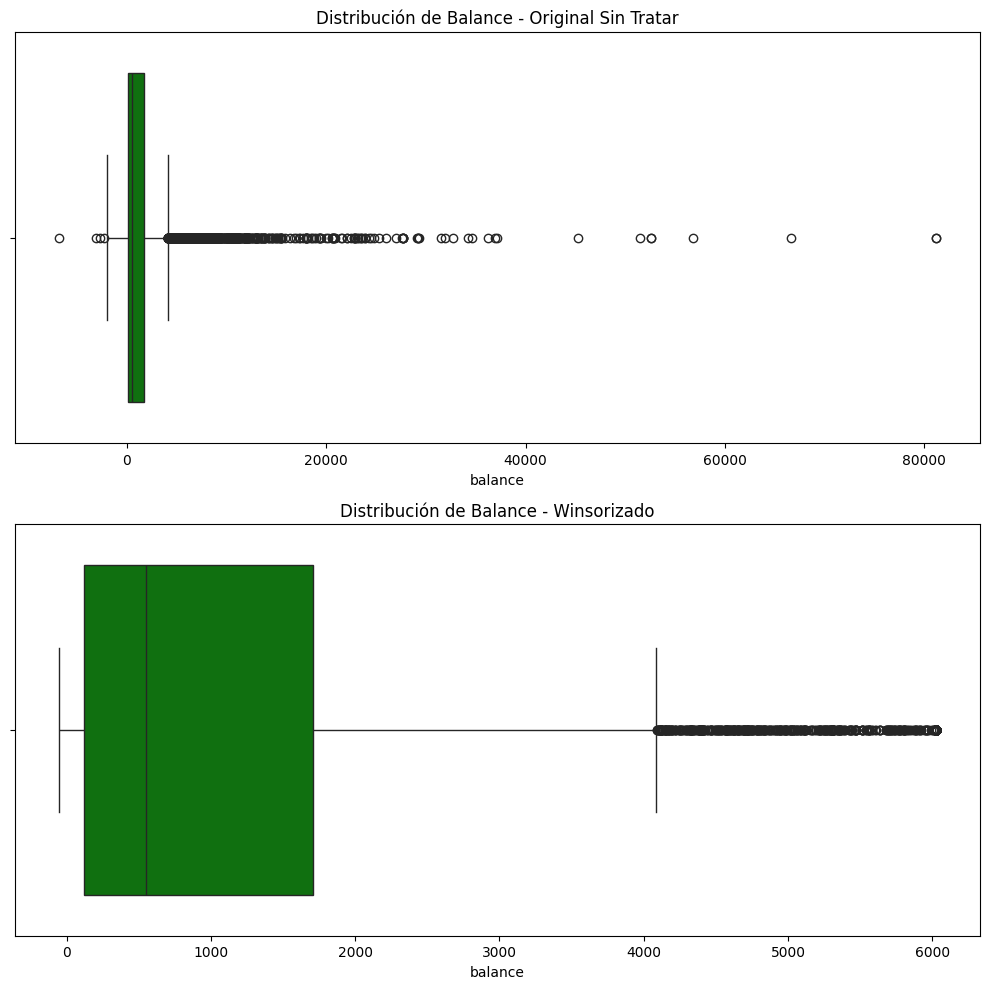

In [87]:
# Creo un contenedor donde realizaré la visualización de ambos boxplots mostrando los datos con y sin winzorización

fig, axes = plt.subplots(2, 1, figsize = (10,10))

sns.boxplot(data = df_bank, x = 'balance', ax = axes[0], color= 'green')
sns.boxplot(data = df_bank_w, x = 'balance', ax = axes[1], color= 'green')

axes[0].set_title('Distribución de Balance - Original Sin Tratar')
axes[1].set_title('Distribución de Balance - Winsorizado')

plt.tight_layout()

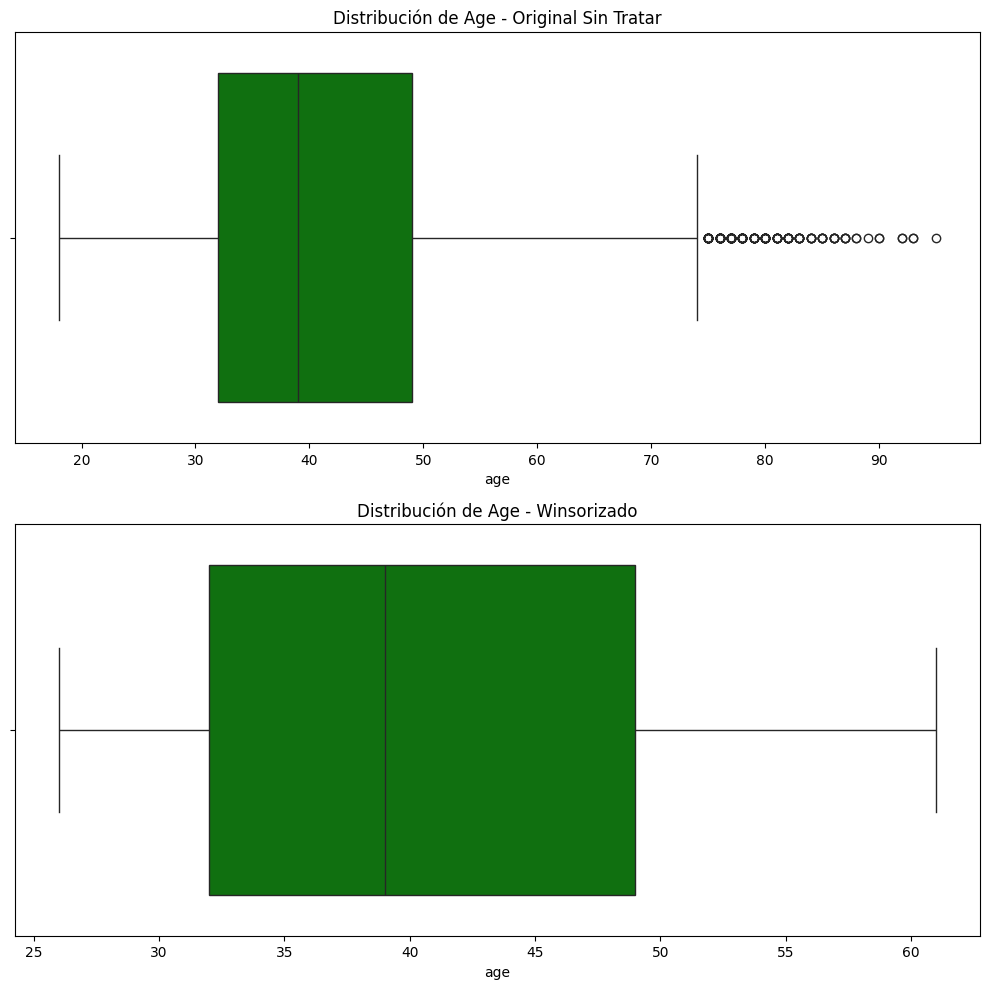

In [88]:
# Creo un contenedor donde realizaré la visualización de ambos boxplots mostrando los datos con y sin winzorización

df_bank_w['age'] = winsorize(df_bank_w['age'], limits= [0.05, 0.05], inplace= True) # Winsorizo  la variable `age`

fig, axes = plt.subplots(2, 1, figsize = (10,10))

sns.boxplot(data = df_bank, x = 'age', ax = axes[0], color= 'green')
sns.boxplot(data = df_bank_w, x = 'age', ax = axes[1], color= 'green')

axes[0].set_title('Distribución de Age - Original Sin Tratar')
axes[1].set_title('Distribución de Age - Winsorizado')

plt.tight_layout()

El  resultado permite tener una mejor agrupación de los balances y las edades; los valores extremos, que pueden sesgar significativamente los estadísticos descriptivos como la media y la desviación estándar, serían atenuados. Al limitar el rango de valores, los resultados de los análisis estadísticos son más representativos de la mayoría de los datos.

Para personalizar el dataframe decido traducir al español los elementos dentro de este y así hacerlo más comprensible a las personas que lo puedan necesitar

In [89]:
df_bank_w["marital"] = np.where(df_bank_w["marital"] == "married", "casado",
                                np.where(df_bank_w["marital"] == "single", "soltero",
                                         "divorciado"))

df_bank_w["education"] = np.where(df_bank_w["education"] == "primary", "primaria",
                                np.where(df_bank_w["education"] == "secondary", "media",
                                         "superior"))

df_bank_w["housing"] = np.where(df_bank_w["housing"] == "no", "no", "sí")

df_bank_w["loan"] = np.where(df_bank_w["loan"] == "no", "no", "sí")

df_bank_w["deposit"] = np.where(df_bank_w["deposit"] == "no", "no", "sí")

# Renombro las columnas

df_bank_w = df_bank_w.rename(columns={
    'age': 'edad',
    'job': 'trabajo',
    'marital': 'estado_civil',
    'education': 'educacion',
    'balance': 'saldo',
    'housing': 'hipoteca',
    'loan': 'prestamos',
    'deposit': 'deposito'
    
})

df_bank_w.head()

,edad,trabajo,estado_civil,educacion,saldo,hipoteca,prestamos,deposito
0,59,profesional,casado,media,2343,sí,no,sí
1,56,profesional,casado,media,45,no,no,sí
2,41,profesional,casado,media,1270,sí,no,sí
3,55,manual,casado,media,2476,sí,no,sí
4,54,profesional,casado,superior,184,no,no,sí


Compruebo que no haya valores nulos después del paso anterior

In [90]:
df_bank_w.isnull().sum()

edad            0
trabajo         0
estado_civil    0
educacion       0
saldo           0
hipoteca        0
prestamos       0
deposito        0
dtype: int64

Codifico las variables:  `educación` para definir su caracter ordinal y las que tienen caracter binario `hipoteca`, `prestamos` y `deposito` (de si/no a 1/0)

In [91]:
educacion_numerica = {'primaria' : 1,
                     'media' : 2,
                     'superior' : 3}

   
df_bank_w['educacion'] = df_bank_w['educacion'].map(educacion_numerica).astype(int)

df_bank_w["hipoteca"] = df_bank_w["hipoteca"].map({"sí": 1, "no": 0})
df_bank_w["prestamos"] = df_bank_w["prestamos"].map({"sí": 1, "no": 0})
df_bank_w["deposito"] = df_bank_w["deposito"].map({"sí": 1, "no": 0})



Compruebo que no hayan valores nulos después de este proceso

In [92]:
df_bank_w.isnull().sum()

edad            0
trabajo         0
estado_civil    0
educacion       0
saldo           0
hipoteca        0
prestamos       0
deposito        0
dtype: int64

Utilizaré Label Encoder para codificar las variables categóricas y así puedan ser tratadas con mayor eficiencia en el algoritmo de ML que he elegido.

In [93]:
categorical_features = ["trabajo", "estado_civil"]

label_encoders = {}

for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    
    df_bank_w[feature + "_encoded"] = label_encoders[feature].fit_transform(df_bank_w[feature])

df_bank_w = df_bank_w.drop(columns=categorical_features, axis=1)

df_bank_w.head()

,edad,educacion,saldo,hipoteca,prestamos,deposito,trabajo_encoded,estado_civil_encoded
0,59,2,2343,1,0,1,3,0
1,56,2,45,0,0,1,3,0
2,41,2,1270,1,0,1,3,0
3,55,2,2476,1,0,1,1,0
4,54,3,184,0,0,1,3,0


Creo una copia del dataframe para entrenar el modelo y tener los datos tratados disponibles.

In [94]:
df_bank_train = df_bank_w.copy()

Estandarizo las Variables Numéricas `edad` y `saldo` con el objetivo de:

- Obtener una convergencia más rápida en el algoritmo.
- Dar un peso similar a las características para evitar que las de mayor rango tengan una influencia desproporcionada en el modelo.
- En K-Means la distancia es importante, si las características tienen escalas diferentes, las distancias se pueden ver distorsionadas y pueden afectar al rendimiento del modelo

In [95]:
# Selecciono solo las columnas a estandarizar
scale_variable = ['edad', 'saldo']

# Creo el escalador 
scaler = StandardScaler()

# Ajusto el escalador y aplico la estandarización al conjunto de datos
df_bank_train[scale_variable] = scaler.fit_transform(df_bank_train[scale_variable])

# Aplico la estandarizacion a los datos de prueba
# X_test[scale_variable] = scaler.transform(X_test[scale_variable])

df_bank_train.head()

,edad,educacion,saldo,hipoteca,prestamos,deposito,trabajo_encoded,estado_civil_encoded
0,1.723571,2,0.644737,1,0,1,3,0
1,1.438779,2,-0.733567,0,0,1,3,0
2,0.014815,2,0.001169,1,0,1,3,0
3,1.343848,2,0.724509,1,0,1,1,0
4,1.248917,3,-0.650197,0,0,1,3,0


Aplico el Método del Codo con el fin de determinar la cantidad ideal de clusters para ejecutar el algoritmo

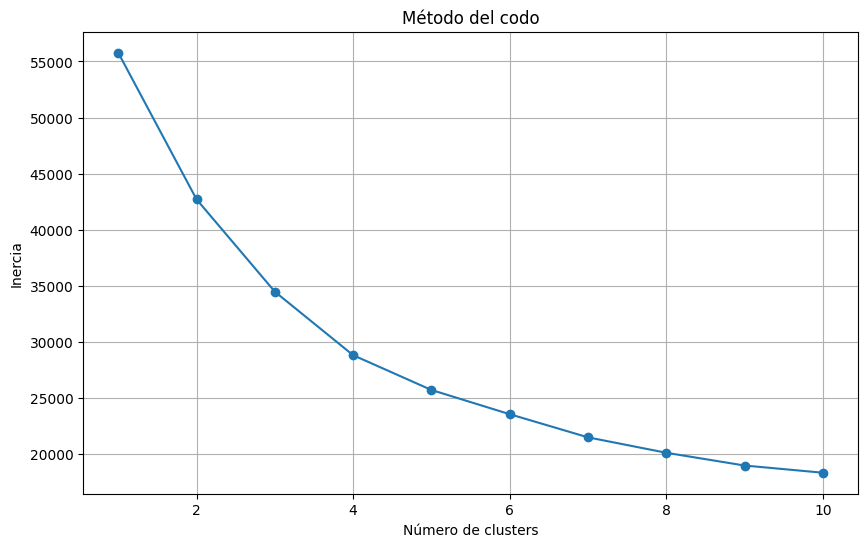

In [96]:
inertia = []

for k in range(1,11):

    kmeans = KMeans(n_clusters = k, 
                    init = "k-means++", 
                    max_iter = 300,
                    n_init = 10,
                    random_state = 42)

    kmeans.fit(df_bank_train)
    
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))

plt.plot(range(1,11), inertia, marker='o')
plt.title("Método del codo")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

Utilizo además el índice de Calinski-Harabasz para obtener una segunda determinación del número óptimo de clusters

In [97]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score


# Lista para almacenar los valores del índice de Calinski-Harabasz
calinski_scores = []

# Rango de número de clusters a evaluar
for num_clusters in range(2, 11):
    # Crear el modelo KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    # Ajustar el modelo a los datos
    kmeans.fit(df_bank_train)
    
    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_
    
    # Calcular el índice de Calinski-Harabasz
    score = calinski_harabasz_score(df_bank_train, labels)
    calinski_scores.append(score)

# Encontrar el número de clusters que maximiza el índice
best_num_clusters = np.argmax(calinski_scores) + 2  # Sumamos 2 porque el rango empieza en 2

print("El número óptimo de clusters según el criterio de Calinski-Harabasz es:", best_num_clusters)

El número óptimo de clusters según el criterio de Calinski-Harabasz es: 3


Después de utilizar los dos métodos decido ejecutar el algoritmo de K-Means Clustering con 4 clusters (En el caso del método del codo encuentro más posibilidades de tener agrupaciones diferenciadas para el objetivo del modelo)

In [98]:
kmeans = KMeans(n_clusters = 4, 
                init="k-means++", 
                max_iter = 300, 
                n_init = 10, 
                random_state = 42)
           
df_bank_train['cluster'] = kmeans.fit_predict(df_bank_train)

Ejecuto Silhouette Score para evaluar la formación de los grupos.

In [99]:
score = silhouette_score(df_bank_train, df_bank_train['cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.34901963438507255


Un resultado de 0.349 puede interpretarse que los grupos han quedado razonablemente bien definidos pero que puede haber cierta sobreposición entre ellos.

No parece una agrupación perfecta, pero es un resultado aceptable, realizaré visualizaciones para comprobarlo.

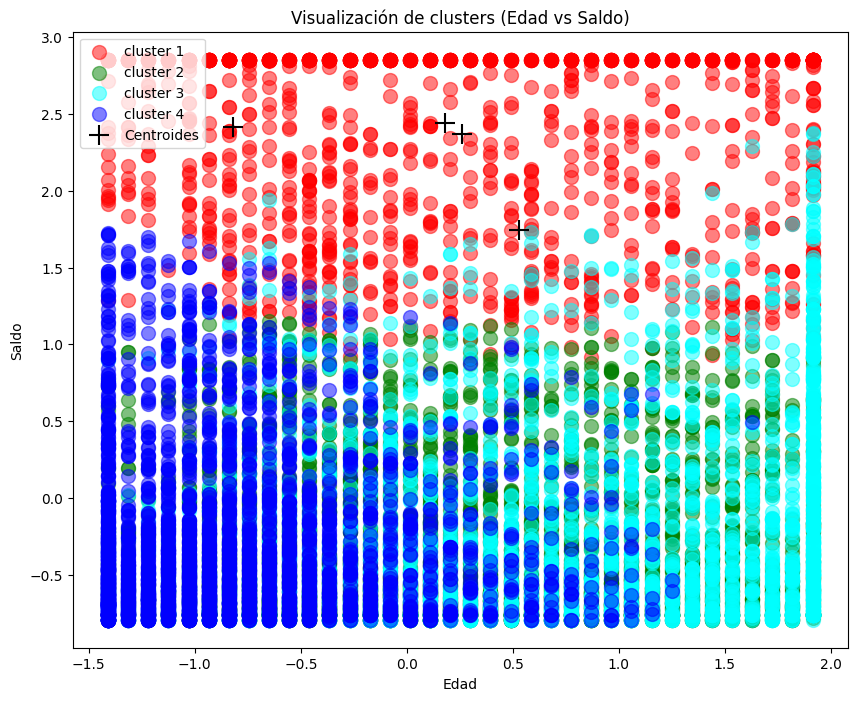

In [100]:
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'cyan', 'blue']

for i in range(4):
    plt.scatter(df_bank_train.loc[df_bank_train['cluster'] == i, 'edad'], 
                df_bank_train.loc[df_bank_train['cluster'] == i, 'saldo'], 
                s = 100, c = colors[i], label = f'cluster {i + 1}', alpha=0.5)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s = 200, c = 'black', marker='+', label='Centroides')

plt.title('Visualización de clusters (Edad vs Saldo)')
plt.xlabel('Edad')
plt.ylabel('Saldo')
plt.legend()
plt.show()

En este gráfico puede notarse la sobreposición de los grupos, realizaré otra visualización para ver los grupos por separado.

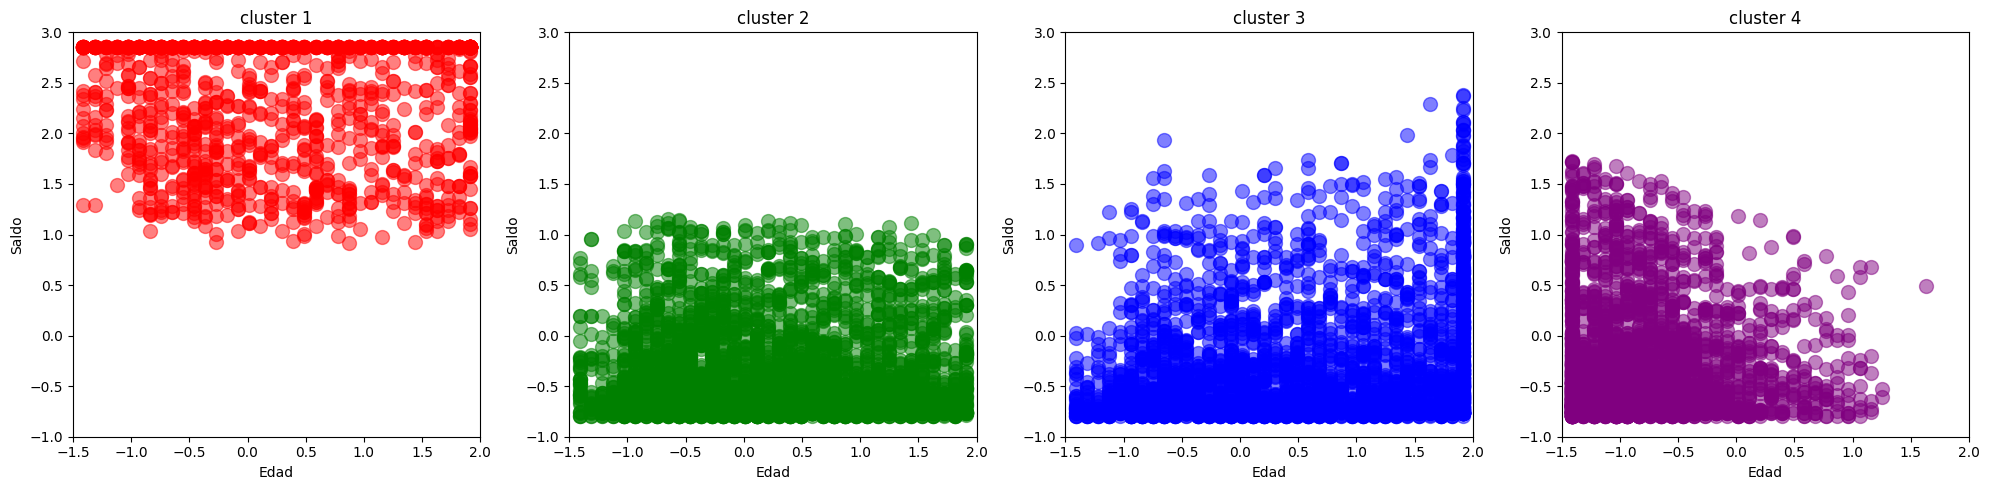

In [101]:
import matplotlib.pyplot as plt

# Creo una figura con subplots (1 fila, 5 columnas para 4 clusters)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Colores para cada cluster
colors = ['red', 'green', 'blue', 'purple']

# Creo un scatter plot para cada cluster en un subplot
for i in range(4):
    axs[i].scatter(df_bank_train.loc[df_bank_train["cluster"] == i, "edad"], 
                   df_bank_train.loc[df_bank_train["cluster"] == i, "saldo"], 
                   c=colors[i], s=100, alpha=0.5)
    axs[i].set_title(f'cluster {i + 1}')  # Título del subplot
    axs[i].set_xlabel('Edad')             # Etiqueta eje X
    axs[i].set_ylabel('Saldo')            # Etiqueta eje Y
    axs[i].set_xlim([-1.5, 2])            # Ajustar límites si es necesario
    axs[i].set_ylim([-1, 3])

plt.tight_layout()

plt.show()


Ahora pueden apreciarse los grupos, parece haber un parecido entre los clusters 2 y 3, pero para poder tener una visión más clara y entender las agrupaciones revertiré las codificaciones para visualizarlos con los valores originales, pero haciendo una copia con el fin de no comprometer los resultados obtenidos.

Realizaré tres visualizaciones para observar las distribuciones entre los clusters:

- Distribución de Observaciones por cluster
- Distribución de los elementos dentro de cada cluster teniendo en cuenta la edad y el saldo en la cuenta bancaria mediante subplots.
- Distribución mediante boxplots de `balance` y `edad`
- Distribución por categorías del conjunto.

Una vez ilustradas las agrupaciones presentaré un resumen de la distribución de los observaciones de las categorías en los clusters y una interpretación de los datos visualizados.

In [102]:
# Reversión de los datos codificados y estandarizados.

df_bank_w_nuevo = df_bank_train.copy()

# Revertir el label encoding para las variables categóricas
for feature in categorical_features:
    df_bank_w_nuevo[feature] = label_encoders[feature].inverse_transform(df_bank_train[feature + "_encoded"])

# Eliminar las columnas codificadas si ya no son necesarias
df_bank_w_nuevo = df_bank_w_nuevo.drop(columns=[f"{feature}_encoded" for feature in categorical_features], axis=1)

# Crear copias de las variables estandarizadas 
df_bank_w_nuevo['edad_original'] = df_bank_w['edad']
df_bank_w_nuevo['saldo_original'] = df_bank_w['saldo']


# Crear diccionario inverso
educacion_numerica_inverso = {v: k for k, v in educacion_numerica.items()}

# Revertir el mapeo
df_bank_w_nuevo['educacion'] = df_bank_train['educacion'].map(educacion_numerica_inverso)
df_bank_w_nuevo["hipoteca"] = df_bank_train["hipoteca"].map({1: "sí", 0: "no"})
df_bank_w_nuevo["prestamos"] = df_bank_train["prestamos"].map({1: "sí", 0: "no"})
df_bank_w_nuevo["deposito"] = df_bank_train["deposito"].map({1: "sí", 0: "no"})

df_bank_w_nuevo.head()

,edad,educacion,saldo,hipoteca,prestamos,deposito,cluster,trabajo,estado_civil,edad_original,saldo_original
0,1.723571,media,0.644737,sí,no,sí,1,profesional,casado,59,2343
1,1.438779,media,-0.733567,no,no,sí,1,profesional,casado,56,45
2,0.014815,media,0.001169,sí,no,sí,1,profesional,casado,41,1270
3,1.343848,media,0.724509,sí,no,sí,2,manual,casado,55,2476
4,1.248917,superior,-0.650197,no,no,sí,1,profesional,casado,54,184


Distribución de Observaciones por cluster

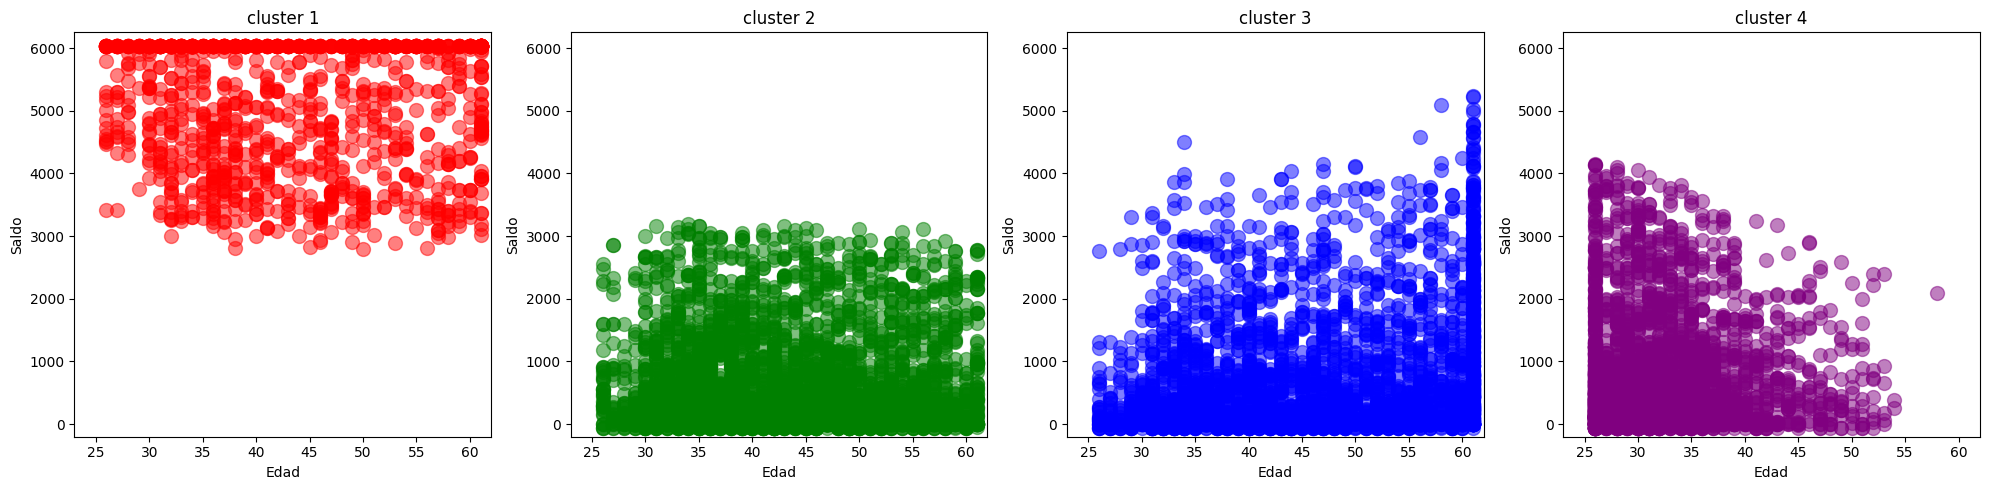

In [103]:
import matplotlib.pyplot as plt

# Crear una figura con subplots (1 fila, 5 columnas para 5 clusters)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Colores para cada cluster
colors = ['red', 'green', 'blue', 'purple', 'blue']

# Crear un scatter plot para cada cluster en un subplot
for i in range(4):
    axs[i].scatter(df_bank_w_nuevo.loc[df_bank_w_nuevo["cluster"] == i, "edad_original"], 
                   df_bank_w_nuevo.loc[df_bank_w_nuevo["cluster"] == i, "saldo_original"], 
                   c=colors[i], s=100, alpha=0.5)
    axs[i].set_title(f'cluster {i + 1}')  # Título del subplot
    axs[i].set_xlabel('Edad')             # Etiqueta eje X
    axs[i].set_ylabel('Saldo')            # Etiqueta eje Y
    axs[i].set_xlim([23, 62])            # He ajustado los límites para que se ajusten lo mejor posible
    axs[i].set_ylim([-200, 6250])

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()

Distribución de la Edad y el Saldo Bancario por Cluster

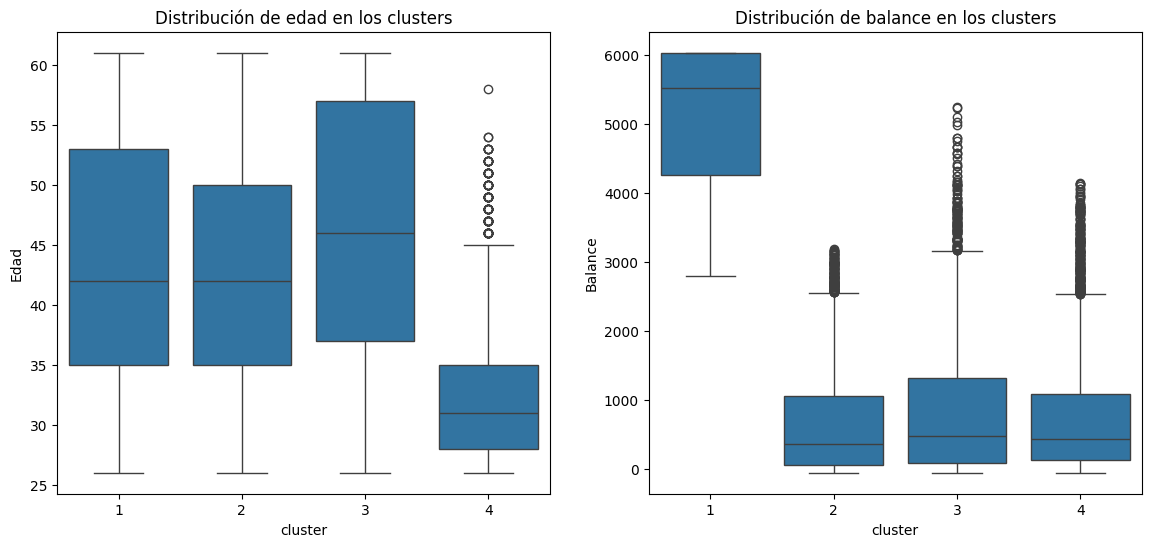

In [125]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.boxplot(x='cluster', y='edad_original', data=df_bank_w_nuevo)
plt.title('Distribución de edad en los clusters')
plt.xlabel("cluster")
plt.ylabel("Edad")
plt.xticks([0, 1, 2, 3], ['1', '2', '3', '4'])

plt.subplot(1, 2, 2)
sns.boxplot(x='cluster', y='saldo_original', data=df_bank_w_nuevo)
plt.title('Distribución de balance en los clusters')
plt.xlabel("cluster")
plt.ylabel("Balance")
plt.xticks([0, 1, 2, 3], ['1', '2', '3', '4'])


plt.show()

Distribución de los elementos(clientes) por cluster mediante uncountplot

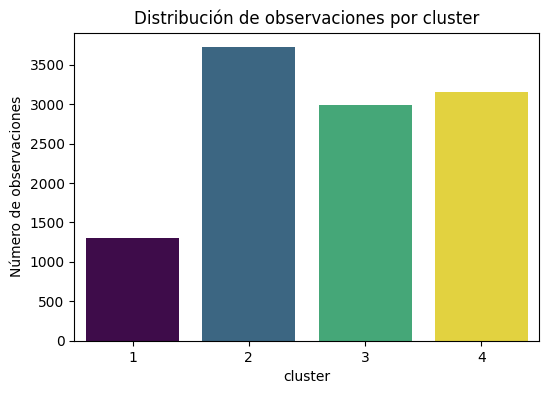

In [105]:
plt.figure(figsize=(6, 4))
sns.countplot(x='cluster', hue='cluster', data=df_bank_w_nuevo, palette="viridis", legend=False)  
plt.title("Distribución de observaciones por cluster")
plt.xlabel("cluster")
plt.ylabel("Número de observaciones")
plt.xticks([0, 1, 2, 3], ['1', '2', '3', '4'])
plt.show()

Distribución de los elementos(clientes) por cluster

In [106]:
df_bank_train['cluster'].value_counts()

cluster
1    3720
3    3156
2    2988
0    1298
Name: count, dtype: int64

Distribución de los elementos(clientes) para el estado civil por cluster

In [107]:
estadocivil_cluster = df_bank_train.groupby(['cluster', 'estado_civil_encoded']).size().reset_index(name='conteo')
estadocivil_cluster

,cluster,estado_civil_encoded,conteo
0,0,0,806
1,0,1,155
2,0,2,337
3,1,0,3118
4,1,1,564
5,1,2,38
6,2,0,2429
7,2,1,448
8,2,2,111
9,3,1,124


Distribución de los elementos(clientes) para trabajo por cluster

In [108]:
trabajo_cluster = df_bank_train.groupby(['cluster', 'trabajo_encoded']).size().reset_index(name='conteo')
trabajo_cluster

,cluster,trabajo_encoded,conteo
0,0,0,89
1,0,1,242
2,0,2,86
3,0,3,881
4,1,2,170
5,1,3,3550
6,2,0,689
7,2,1,2216
8,2,2,83
9,3,1,683


Distribución de los elementos(clientes) de educación por cluster

In [109]:
educacion_cluster = df_bank_train.groupby(['cluster', 'educacion']).size().reset_index(name='conteo')
educacion_cluster

,cluster,educacion,conteo
0,0,1,150
1,0,2,521
2,0,3,627
3,1,1,159
4,1,2,1751
5,1,3,1810
6,2,1,1066
7,2,2,1610
8,2,3,312
9,3,1,125


Distribución de los elementos(clientes) con hipoteca por cluster

In [110]:
hipoteca_cluster = df_bank_train.groupby(['cluster', 'hipoteca']).size().reset_index(name='conteo')
hipoteca_cluster

,cluster,hipoteca,conteo
0,0,0,763
1,0,1,535
2,1,0,1966
3,1,1,1754
4,2,0,1414
5,2,1,1574
6,3,0,1738
7,3,1,1418


Distribución de los elementos(clientes) con préstamos contratados por cluster

In [111]:
prestamos_cluster = df_bank_train.groupby(['cluster', 'prestamos']).size().reset_index(name='conteo')
prestamos_cluster

,cluster,prestamos,conteo
0,0,0,1215
1,0,1,83
2,1,0,3138
3,1,1,582
4,2,0,2529
5,2,1,459
6,3,0,2820
7,3,1,336


Distribución de los elementos(clientes) con deposito contratado por cluster

In [112]:
deposito_cluster = df_bank_train.groupby(['cluster', 'deposito']).size().reset_index(name='conteo')
deposito_cluster

,cluster,deposito,conteo
0,0,0,548
1,0,1,750
2,1,0,2144
3,1,1,1576
4,2,0,1735
5,2,1,1253
6,3,0,1446
7,3,1,1710


Distribución de las categorías del conjunto de datos.

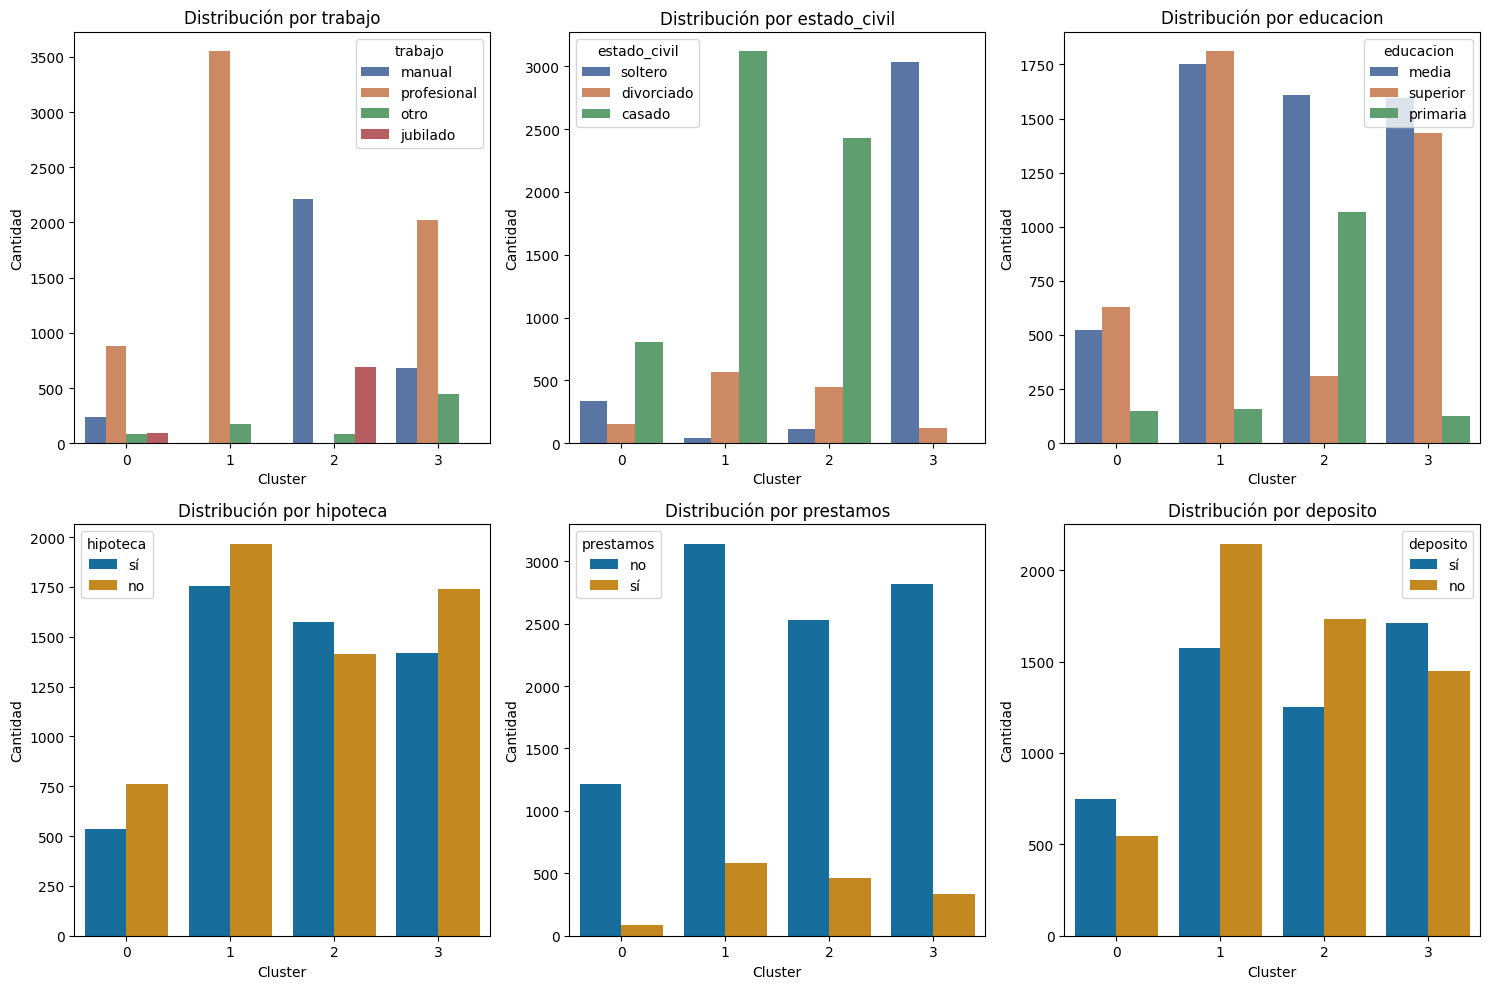

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_vars = ['trabajo','estado_civil', 'educacion']
contract_vars = ['hipoteca','prestamos', 'deposito']

# Lista de listas para agrupar las variables
all_vars = [categorical_vars, contract_vars]

# Número de filas y columnas deseadas
nrows, ncols = 2, 3

# Crear la figura
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))  

# Iterar sobre los grupos de variables y crear los subplots
for row_idx, var_group in enumerate(all_vars):
    for col_idx, var in enumerate(var_group):
        ax = axes[row_idx, col_idx]
        sns.countplot(x='cluster', hue=var, data=df_bank_w_nuevo, ax=ax, palette='deep' if row_idx == 0 else 'colorblind')
        ax.set_title(f'Distribución por {var}')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Cantidad')

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

# Interpretación de la aplicación del Algoritmo

La distribución de la agrupación de los clusters muestra los siguientes resultados:

`Cluster 1`:

- Elementos: 1298
- Rango de Edad: 35-53 años
- Estado Civil: Mayoría Casados(806), solteros(337) y menor presencia de divorciados (155)
- Nivel de Ingresos/Ahorro: Altos.
- Nivel de Estudios: Proporción equilibrada entre Nivel Superior(627) y Eduacación Media(521), siendo menor la Primaria(150)
- Tipo de Trabajo: Mayoría de Profesionales(881), Manual(242), Jubilados(89) y Otros(85).
- Hipoteca: Clientes con Hipoteca`Sí`(535) y `No`(763)
- Préstamos: Sin préstamos (1215) y con préstamos(83)
- Deposito contratado: `No`(548) y `Sí`(750)
- Perfil: Profesionales con altos Ingresos y Educación, con una ligera inclinación a no contratar productos bancarios masivos.

-   `Productos Financieros Recomendados Línea de Productos Platinum:`

    - Fondos de inversión diversificados (acciones, bonos).
    - Cuentas premium con servicios exclusivos (gestores personalizados).
    - Seguros de vida y salud de alta gama
    - Planes de inversión a largo plazo o jubilación privada.
    - Productos bancarios sostenibles o de impacto social.

`Cluster 2`:

- Elementos: 2988
- Rango de Edad: 38-55 años.
- Nivel de Ingresos: Medios con una tendencia al ahorro.
- Estado Civil: Mayoría de Casados(2429), Divorciados(448) y Solteros(111)
- Tipo de Trabajo: Mayoría de trabajadores manuales(2216) con presencia de Jubilados(689) y Otros(83)
- Nivel de Estudios: Proporciones de Nivel Primaria(1066), Media(1610) y Superior(312)
- Hipoteca: No(1414) superior a `Sí`(1574)
- Préstamo: La cantidad de clientes sin préstamos es superior `No`:(2529) y `Sí`(459)
- Deposito Contratado: Hay tantos clientes que `No` han contratado (1735) que `Sí`(1253)
- Perfil: Trabajadores manuales estables, con tendencia al ahorro y mayoritariamente casados.

- ` Productos Financieros Recomendados Línea de Productos Access Gold: `

    -	Cuentas de ahorro con bonificaciones por saldos altos.
    -	Depósitos a plazo fijo con intereses atractivos.
    -	Planes de pensiones individuales para complementar ingresos futuros.
    -	Seguros de vida o de protección familiar.
    -   Productos bancarios vinculados a la vivienda (hipotecas a tipo fijo, seguros de hogar)

`Cluster 3`:

- Elementos: 3720
- Rango de Edad: 35-49
- Estado Civil: Mayoría de casados(3188), Divorciados(564) y Solteros(38)
- Nivel de Ingresos/Ahorro: Mayoría de bajos con algunos de ingresos/ahorro medios.
- Tipo de Trabajo: Mayoría de trabajos profesionales (obreros, servicios y domésticos) 3550 y mínima presencia de otros(170)
- Nivel de Estudios: Superior(1810), Media(1751) y Primaria(159)
- Hipoteca: Clientes con Hipoteca`Sí`(1754) y `No`(1966)
- Préstamos: Con préstamos (582) y sin préstamos(3138)
- Deposito contratado: `No`(2144) y `Sí`(1576)
- Perfil: Trabajadores profesionales y manuales, con ingresos bajos y obligaciones financieras.

-   `Productos Financieros Recomendados Linea de Productos Silver:`

    - Cuentas de ahorro sencillas con incentivos para clientes leales, tarjetas de débito.
    - Microcréditos para necesidades específicas (educación, salud, mejoras de vivienda).
    - Reestructuración de deuda (hipotecas y préstamos).
    - Planes de ahorro para metas específicas (ejemplo: educación de hijos).

`Cluster 4`:

- Elementos: 3156 
- Rango de Edad entre 25-35.
- Estado Civil: Mayoritariamente Solteros (3032) y presencia de divorciados (124)
- Nivel de Ingresos: Bajos.
- Tipo de Trabajo: Mayoría de trabajo profesional(2025), seguido de trabajo manual(683) y Otros(448)
- Nivel de Estudios: Proporciones equilibradas de Nivel Medio(1597) y Superior(1434)
- Hipoteca: Mayor cantidad `No`(1738) que `Sí`(1418)
- Préstamos: Mayoría de `No`(2820) que `Sí`(336)
- Deposito contratado: Cantidades equilibradas de `Sí`(1710) y `No`(1446)
- Perfil: Jóvenes profesionales solteros o recién casados, con hipoteca e inclinados a contratar depositos.

-   `Productos Financieros Recomendados Línea de Productos Flex:`

    - Cuentas de ahorro con beneficios para jóvenes (ejemplo: sin comisiones).
    - Depósitos a corto plazo con flexibilidad para retiro temprano.
    - Préstamos personales de bajo monto con tasas competitivas.
    - Educación financiera y productos de inversión iniciales.
    - Tarjetas de crédito con beneficios para jóvenes.
    - Productos Bancarios Digitales



Realizo la aplicación del Coeficiente de Silueta y el Índice de Calinski-Harabasz para evaluar la aplicación del algoritmo

In [114]:
# Coeficiente de Silueta
silhouette_avg = silhouette_score(df_bank_train, df_bank_train['cluster'])
print("Coeficiente de silueta:", silhouette_avg)

Coeficiente de silueta: 0.34901963438507255


In [115]:
# Índice Calinski-Harabasz
calinski_harabasz_score = calinski_harabasz_score(df_bank_train, df_bank_train['cluster'])
print("Índice de Calinski-Harabasz:", calinski_harabasz_score)

Índice de Calinski-Harabasz: 4923.845403522177


El `Coeficiente de Silueta` indica una separación moderada entre los clusters, están razonablemente bien definidos; aunque los clusters son distinguibles, hay cierta superposición entre ellos. Esto podría indicar que algunos clientes en un cluster podrían ser similares a los de otro.

En el caso del `Índice de Calinski-Harabasz`, aunque no existe un umbral absoluto para este índice, este valor parece indicar que la partición obtenida es razonable en términos de separación y cohesión interna.

`Conclusión:`

La aplicación de este algoritmo de clustering sugiere una segmentación útil para personalizar la oferta de productos. Aunque los índices de calidad indican áreas de mejora (como la superposición de clusters), los perfiles identificados permiten diseñar estrategias enfocadas en las necesidades y comportamiento de cada grupo.

Los clusters parecen estar razonablemente bien definidos, aunque se podría explorar el uso de diferentes características o técnicas de preprocesamiento para mejorar la definición de los clusters, además de considerar otros algoritmos de clustering para complementar este.

Guardo el modelo, el escalador y el codificador para utilizarlos en la implementación de APP mediante Streamlit

In [116]:
import pickle

# guardo el modelo
with open('kmeans.pkl', 'wb') as model_file:
    pickle.dump(kmeans, model_file)

# guardo el escalador
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Guardo el Label Encoder
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

Realizo una prueba introduciendo datos de un tipo de cliente (en este caso un joven de 23 años, soltero(2), con educación superior(2), estudiante, un saldo bancario bajo(750€, sin hipoteca, sin préstamo contratado y sin haber contratado el deposito de la campaña telefónica del banco))

In [139]:
import pandas as pd

# Nueva entrada
nueva_entrada = {
    "edad": [23],       # Introducir el valor que corresponda 
    "educacion": [3],   # Primaria= 1, Media(Secundaria/Bachillerato)= 2, Superior= 3
    "saldo": [2000],     # Introducir el valor que corresponda   
    "hipoteca": [0],    # Si=1, No=0 
    "prestamos": [0],   # Si=1, No=0 
    "deposito": [0],    # Si=1, No=0 
    "trabajo_encoded": [2], # Jubilado=0, Manual(obreros, construcción, servicios)=1, Otro=2(estudiantes, amas de casa y desempleados ) y Profesional=3(administración, técnicos, emprendedores, gerentes)
    "estado_civil_encoded": [2] # Valores para Casados=0, Divorciados=1 y Solteros=2
}

# Convertir a DataFrame
nuevo_dato = pd.DataFrame(nueva_entrada)

# Escalar las variables numéricas
scale_variable = ['edad', 'saldo']
nuevo_dato[scale_variable] = scaler.transform(nuevo_dato[scale_variable])

# Predecir el cluster


perfil_map = {
    0: "1: Línea de Productos Platinum ",
    1: "2: Línea de Productos Gold",
    2: "3: Línea de Productos Silver",
    3: "4: Linea de Productos Flex",
}

cluster_predicho = kmeans.predict(nuevo_dato)

# Accediendo al valor del diccionario usando la predicción como clave
perfil = perfil_map.get(cluster_predicho.item(), "Perfil no encontrado")

print(f'El cliente pertenece al perfil: {perfil}')



El cliente pertenece al perfil: 4: Linea de Productos Flex


In [118]:
with open('kmeans.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

loaded_model

KMeans(n_clusters=4, n_init=10, random_state=42)